In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import timedelta

# === Carica dati di mercato ===
df_mkt = pd.read_csv("Market.csv", thousands=",", decimal=".")
df_mkt["Date"] = pd.to_datetime(df_mkt["Date"], dayfirst=False)
df_mkt = df_mkt.sort_values("Date").set_index("Date")
df_mkt["mkt_return"] = df_mkt["Price"].pct_change()

# === Carica earnings dates ===
earnings_all = pd.read_excel("earnings_dates.xlsx")
earnings_all["Date"] = pd.to_datetime(earnings_all["Date"])
tickers = earnings_all["Ticker"].unique()

# === Lista risultati aggregati ===
all_measures = []

for ticker in tickers:
    path = f"{ticker}.csv"
    if not os.path.exists(path):
        print(f"File {path} non trovato.")
        continue

    df_stock = pd.read_csv(path, thousands=",", decimal=".")
    df_stock["Date"] = pd.to_datetime(df_stock["Date"], dayfirst=False)
    df_stock = df_stock.sort_values("Date").set_index("Date")
    df_stock["return"] = df_stock["Price"].pct_change()

    # Merge con dati di mercato
    df = pd.merge(df_stock[["Price", "return"]], df_mkt[["mkt_return"]], left_index=True, right_index=True)
    df["adj_return"] = df["return"] - df["mkt_return"]
    df["log_adj_return"] = np.log(1 + df["adj_return"])
    df["volatility_adj"] = df["log_adj_return"].rolling(window=22).std()
    df["jump"] = abs(df["log_adj_return"]) / df["volatility_adj"]

    earnings = earnings_all[earnings_all["Ticker"] == ticker].copy().sort_values("Date")

    for edate in earnings["Date"]:
        future = df[df.index >= edate]
        if future.empty:
            continue
        selected_date = future.index[0]
        idx = df.index.get_loc(selected_date)

        # Jump
        jump = df.loc[selected_date, "jump"] if selected_date in df.index else np.nan

        # DM (Sammon)
        try:
            window = df.loc[selected_date - timedelta(days=40):selected_date].tail(23)
            if len(window) < 23:
                continue
            pre_returns = window["adj_return"].iloc[:-1].values
            r_t = window["adj_return"].iloc[-1]
            gross_pre = np.prod(1 + pre_returns)
            dm = 100 * (1 / (1 + r_t)) if r_t > 0 else 100 * (1 + r_t)
        except:
            dm = np.nan

        # QVS
        try:
            if idx >= 22:
                window_qvs = df.iloc[idx-22:idx+1]
                sum_r2_pre = (window_qvs["adj_return"].iloc[:-1] ** 2).sum()
                sum_r2_total = (window_qvs["adj_return"] ** 2).sum()
                qvs = 100 * sum_r2_pre / sum_r2_total if sum_r2_total != 0 else np.nan
            else:
                qvs = np.nan
        except:
            qvs = np.nan

        all_measures.append({
            "Ticker": ticker,
            "Earnings Date": edate,
            "Used Date": selected_date,
            "Jump": round(jump, 4) if pd.notna(jump) else np.nan,
            "DM": round(dm, 2),
            "QVS": round(qvs, 2) if pd.notna(qvs) else np.nan
        })

# === Crea DataFrame finale ===
df_measures = pd.DataFrame(all_measures)
df_measures_sorted = df_measures[["Ticker", "Earnings Date", "Used Date", "Jump", "DM", "QVS"]].sort_values(by=["Ticker", "Earnings Date"])
df_measures_sorted.to_excel("measures.xlsx", index=False)

# === Media per earnings date ===
df_mean = df_measures.groupby("Earnings Date")[["Jump", "DM", "QVS"]].mean().dropna()


In [2]:
df_stock = pd.read_csv(path, thousands=",", decimal=".")
print(df_stock.columns.tolist())

['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


In [3]:

# === Visualizza tabella finale ===
from IPython.display import display
display(df_measures_sorted)


,Ticker,Earnings Date,Used Date,Jump,DM,QVS
42,3800-HK,2015-03-26,2015-03-26,0.6302,98.24,98.34
43,3800-HK,2015-08-28,2015-08-28,1.6124,94.61,87.19
44,3800-HK,2016-03-23,2016-03-23,1.1837,96.34,93.62
45,3800-HK,2016-08-24,2016-08-24,0.2656,99.58,99.74
46,3800-HK,2017-03-29,2017-03-29,1.2743,97.99,92.11
...,...,...,...,...,...,...
564,VRT-US,2024-04-24,2024-04-24,1.9405,93.63,81.17
565,VRT-US,2024-07-24,2024-07-24,3.0825,88.18,58.38
566,VRT-US,2024-10-23,2024-10-23,1.2428,97.25,93.46
567,VRT-US,2025-02-12,2025-02-12,1.2158,90.43,91.87


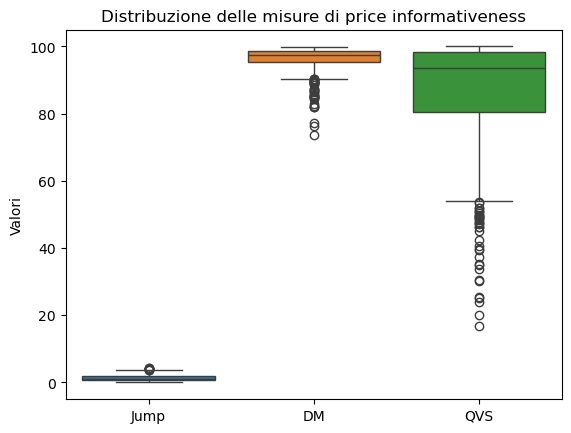

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot delle tre misure di price informativeness
sns.boxplot(data=df_mean[['Jump', 'DM', 'QVS']])
plt.title("Distribuzione delle misure di price informativeness")
plt.ylabel("Valori")
plt.show()

In [5]:
display(df_mean)

,Jump,DM,QVS
Earnings Date,,,
2015-02-05,0.641200,96.850,98.080000
2015-02-12,1.249100,95.755,89.520000
2015-02-13,2.891167,91.940,57.513333
2015-02-17,2.182000,91.770,80.680000
2015-02-19,0.390700,99.320,99.330000
...,...,...,...
2025-05-05,0.453500,97.380,99.050000
2025-05-06,1.558800,92.730,87.340000
2025-05-07,0.510050,97.640,98.510000


#### import pandas as pd
import matplotlib.pyplot as plt

# df_mean deve avere index = date (earnings) e colonne ["Jump","DM","QVS"]

# 1) media mensile (ultimo giorno di mese: 'ME' sostituisce 'M')
df_month = df_mean.resample("ME").mean().sort_index()

# 2) rendi la serie continua
#   - prima interpolazione lineare sui buchi
#   - poi, se restano NaN alle estremità, ffill/bfill

df_month = df_month.ffill().bfill()

# --- grafico Jump ---
plt.figure(figsize=(11,5))
plt.plot(df_month.index, df_month["Jump"], marker="o")
plt.title("Jump medio (mensile)")
plt.xlabel("Mese"); plt.ylabel("Jump")
plt.xticks(rotation=45); plt.grid(True); plt.tight_layout()
plt.show()

# --- grafico DM ---
plt.figure(figsize=(11,5))
plt.plot(df_month.index, df_month["DM"], marker="o")
plt.title("DM medio (mensile)")
plt.xlabel("Mese"); plt.ylabel("DM")
plt.xticks(rotation=45); plt.grid(True); plt.tight_layout()
plt.show()

# --- grafico QVS ---
plt.figure(figsize=(11,5))
plt.plot(df_month.index, df_month["QVS"], marker="o")
plt.title("QVS medio (mensile)")
plt.xlabel("Mese"); plt.ylabel("QVS (%)")
plt.xticks(rotation=45); plt.grid(True); plt.tight_layout()
plt.show()

In [7]:
# --- Medie mensili ---
df_month = df_mean.resample("ME").mean().sort_index()
df_month = df_month.interpolate(method="linear", limit_direction="both").ffill().bfill()

# --- Medie annuali ---
df_year = df_mean.resample("YE").mean().sort_index()
df_year = df_year.interpolate(method="linear", limit_direction="both").ffill().bfill()

# Stampa
print("=== Medie mensili ===")
print(df_month.head(100))

print("\n=== Medie annuali ===")
print(df_year.head(100))


=== Medie mensili ===
                   Jump         DM        QVS
Earnings Date                                
2015-02-28     1.258957  94.066111  87.363704
2015-03-31     1.428525  97.142500  90.120000
2015-04-30     1.326612  96.668750  92.311250
2015-05-31     1.277069  97.672222  90.013889
2015-06-30     1.653689  96.594132  84.387882
...                 ...        ...        ...
2023-01-31     1.464200  96.950000  87.960000
2023-02-28     1.155458  97.613462  90.438462
2023-03-31     0.198000  99.510000  99.960000
2023-04-30     1.736851  96.330417  81.795694
2023-05-31     0.938055  97.874000  95.074500

[100 rows x 3 columns]

=== Medie annuali ===
                   Jump         DM        QVS
Earnings Date                                
2015-12-31     1.486041  95.455033  86.109641
2016-12-31     1.299889  96.182632  87.437052
2017-12-31     1.625360  96.373003  83.071108
2018-12-31     1.485501  96.206129  84.718874
2019-12-31     1.340574  96.933828  85.819661
2020-12-31 

In [8]:
import os

# Percorso cartella Download
download_path = os.path.expanduser("~/Downloads/medie_informativeness.xlsx")

# Salva mese e anno in due sheet
with pd.ExcelWriter(download_path) as writer:
    df_month.to_excel(writer, sheet_name="Medie Mensili")
    df_year.to_excel(writer, sheet_name="Medie Annuali")

print(f"File salvato in: {download_path}")

File salvato in: /Users/andreaaime/Downloads/medie_informativeness.xlsx


In [18]:
import pandas as pd

# Assumo che df_mean abbia come indice le date e le colonne "Jump", "DM", "QVS"
df_mean.index = pd.to_datetime(df_mean.index)

# Funzione per calcolare le medie su due periodi
def calc_means(df, col):
    mean_2015_2021 = df.loc["2015-01-01":"2021-12-31", col].mean()
    mean_2022_2025 = df.loc["2022-01-01":"2025-12-31", col].mean()
    return mean_2015_2021, mean_2022_2025

# Calcolo per ogni misura
jump_1, jump_2 = calc_means(df_mean, "Jump")
dm_1, dm_2 = calc_means(df_mean, "DM")
qvs_1, qvs_2 = calc_means(df_mean, "QVS")

# Creo tabella riassuntiva
results = pd.DataFrame({
    "Periodo": ["2015-2021", "2022-2025"],
    "Jump medio": [jump_1, jump_2],
    "DM medio": [dm_1, dm_2],
    "QVS medio": [qvs_1, qvs_2]
})

print(results)

     Periodo  Jump medio   DM medio  QVS medio
0  2015-2021    1.383472  96.338524  86.438605
1  2022-2025    1.204568  96.505646  88.468509
